In [113]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.model_selection import TimeSeriesSplit, train_test_split, cross_val_score
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
%xmode Minimal

Exception reporting mode: Minimal


In [114]:
df = pd.read_csv('../data/csv/games_data_2.csv')
team_stats_by_season = pd.read_csv('../data/csv/team_stats.csv') # Статистика каждой команды в сезоне

In [115]:
# Вычисление дробных значений в таблице
team_stats_by_season['% Побед дома'] = team_stats_by_season['Побед дома'].apply(
    lambda x: round(int(x.split('-')[0]) / int(x.split('-')[1]) if int(x.split('-')[1]) != 0 else int(x.split('-')[0]),
                    2)).copy()
team_stats_by_season['% Побед в гостях'] = team_stats_by_season['Побед в гостях'].apply(
    lambda x: round(int(x.split('-')[0]) / int(x.split('-')[1]) if int(x.split('-')[1]) != 0 else int(x.split('-')[0]),
                    2)).copy()
team_stats_by_season.drop(columns=['Побед дома'], inplace=True)
team_stats_by_season.drop(columns=['Побед в гостях'], inplace=True)

In [116]:
# Выборка нечисловых значений
float_fields = [x for x in df.keys() if x.endswith('3/В') or x.endswith('В прот.')]
percent_fields = [x for x in df.keys() if x.endswith('%') or x.endswith('% прот.')]

# Представление нечисловых значений в процентах
for fl in float_fields:
    df[fl] = df[fl].apply(lambda x: int(x.split('/')[0]) / int(x.split('/')[1]) if '/' in x else 0)

for per in percent_fields:
    df[per] = df[per].apply(lambda x: int(x) / 100 if x > 0 else 0)

In [117]:
df = df.dropna(axis=0, how='any')

In [118]:
# Создание столбца Сезон
def get_season(date_str):
    year = int(date_str.split()[-1])
    if year == 2024:
        return 2024
    return f"{year + 1}"

In [119]:
df['Сезон'] = df['Дата'].apply(get_season)
df = df.drop(df.filter(regex='3/В').columns, axis=1)

In [120]:
df

,Очки,2-очк-%,3-очк-%,Штрафные-%,Подборы,Передачи,Фолы,Перехваты,Потери,Блокшоты,...,Фолы прот.,Перехваты прот.,Потери прот.,Блокшоты прот.,Имя,Имя прот.,Победа,Победа дома,Дата,Сезон
0,67,0.41,0.40,0.79,27,14,19,5,13,1,...,20,7,8,7,Нимбурк,Локомотив-Кубань,0,0,3 октября 2014,2015
1,89,0.51,0.41,0.71,31,24,20,14,13,2,...,16,6,20,3,Химки,Автодор,1,1,6 октября 2014,2015
2,95,0.52,0.27,0.74,42,20,24,5,12,2,...,26,9,13,3,Зенит,Нимбурк,1,1,6 октября 2014,2015
3,95,0.57,0.43,0.93,29,18,20,5,10,4,...,25,4,11,2,Красные Крылья,Нимбурк,1,1,8 октября 2014,2015
4,99,0.67,0.32,0.85,40,19,18,9,13,7,...,21,6,15,1,ЦСКА,Байзонс,1,1,8 октября 2014,2015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2086,81,0.64,0.28,0.92,31,23,30,10,10,2,...,27,6,19,3,МБА,Минск,1,1,14 апреля 2024,2024
2087,77,0.44,0.32,0.75,39,21,23,12,15,4,...,19,8,18,4,Зенит,Парма,1,1,14 апреля 2024,2024
2088,80,0.39,0.50,0.76,36,23,17,5,11,2,...,21,6,10,2,Уралмаш,Самара,1,1,17 апреля 2024,2024
2089,79,0.47,0.33,0.76,39,11,26,4,17,6,...,25,6,8,6,Автодор,МБА,0,0,17 апреля 2024,2024


In [121]:
# Выборка статистики команд за каждый сезон
def get_team_season_stats(team_name: str):
    # Объединение данных, где команда упоминается как "Имя" и как "Имя противника"
    team_stats = df[(df['Имя'] == team_name)].copy()

    # Упрощение данных для работы
    team_stats['Имя'] = team_stats.apply(lambda row: team_name, axis=1)

    # Агрегирование данных по сезонам и командам
    grouped = team_stats.groupby(['Сезон', 'Имя'])

    team_season_stats = grouped.agg({
        '2-очк-%': 'mean',
        '3-очк-%': 'mean',
        'Штрафные-%': 'mean',
        'Подборы': 'mean',
        'Передачи': 'mean',
        'Фолы': 'mean',
        'Перехваты': 'mean',
        'Потери': 'mean',
        'Блокшоты': 'mean',
    }).reset_index()

    # Преобразование типа данных столбца "Сезон" в строковый
    team_season_stats['Сезон'] = team_season_stats['Сезон'].astype(str)
    team_stats_by_season['Сезон'] = team_stats_by_season['Сезон'].astype(str)

    # Добавление данных из таблицы team_stats_by_season
    team_season_stats = pd.merge(team_season_stats, team_stats_by_season, how='inner', on=['Сезон', 'Имя'])

    return team_season_stats
result_data = get_team_season_stats('ЦСКА').drop(0)
result_data

,Сезон,Имя,2-очк-%,3-очк-%,Штрафные-%,Подборы,Передачи,Фолы,Перехваты,Потери,Блокшоты,Матчей,Выиграно,Проиграно,%побед,Забито,Пропущено,Разница,% Побед дома,% Побед в гостях
1,2015,ЦСКА,0.530000,0.386250,0.791250,35.125000,20.500000,16.875000,11.375000,12.000000,5.125000,30,26,4,86.7,90.4,71.7,18.7,6.5,6.50
2,2016,ЦСКА,0.583182,0.471364,0.752273,34.454545,23.454545,20.863636,10.090909,11.590909,3.363636,30,28,2,93.3,95.2,74.3,20.9,14.0,14.00
3,2017,ЦСКА,0.614444,0.416111,0.780000,31.333333,23.111111,22.500000,8.944444,13.888889,4.388889,24,22,2,91.7,94.8,74.3,20.5,12.0,5.00
4,2018,ЦСКА,0.606667,0.380833,0.830833,31.666667,23.666667,20.083333,7.500000,11.250000,3.583333,24,22,2,91.7,94.5,78.9,15.6,11.0,11.00
5,2019,ЦСКА,0.592500,0.419167,0.842500,30.416667,21.000000,21.416667,8.583333,11.500000,2.666667,26,22,4,84.6,92.5,75.7,16.7,12.0,3.33
6,2020,ЦСКА,0.593571,0.394286,0.811429,31.071429,18.928571,20.071429,7.357143,10.928571,3.428571,19,15,4,78.9,89.8,76.3,13.5,7.0,2.67
7,2021,ЦСКА,0.566667,0.465000,0.783333,32.000000,22.333333,20.500000,7.666667,9.666667,3.500000,24,17,7,70.8,92.5,77.5,14.9,3.0,2.00
8,2022,ЦСКА,0.628889,0.421111,0.795556,31.222222,20.888889,19.666667,7.888889,13.000000,3.777778,18,15,3,83.3,88.7,70.0,18.7,8.0,3.50
9,2023,ЦСКА,0.584444,0.407778,0.786667,35.888889,22.666667,18.777778,8.555556,12.333333,4.222222,36,25,11,69.4,86.3,77.9,8.5,2.6,2.00
10,2024,ЦСКА,0.607778,0.382222,0.867778,29.444444,20.444444,20.000000,6.666667,10.777778,3.000000,36,25,11,69.4,86.3,77.9,8.5,2.6,2.00


In [122]:
dataset = pd.merge(df, team_stats_by_season, on=['Имя', 'Сезон'], how='left')
team_stats_by_season_prot = team_stats_by_season.rename(columns=lambda x: x + ' прот.' if x not in ['Сезон', 'Имя'] else x)

# Объединение данных по имени противника
dataset = pd.merge(dataset, team_stats_by_season_prot, left_on=['Имя прот.', 'Сезон'], right_on=['Имя', 'Сезон'], how='left')

In [123]:
# Целевой признак
def add_target(team):
    team['Цель'] = team['Победа']
    return team

In [124]:
# Группировка данных по имени с добавлением столбца Цель
dataset = dataset.groupby('Имя_x', group_keys=False).apply(add_target).copy().dropna().reset_index(drop=True)
dataset['Цель'] = dataset['Цель'].astype(int, errors='ignore')

dataset.rename(columns={'Имя_x': 'Имя'}, inplace=True)
dataset.drop(columns=['Имя_y'], inplace=True)

dataset

/tmp/ipykernel_7263/3032490024.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  dataset = dataset.groupby('Имя_x', group_keys=False).apply(add_target).copy().dropna().reset_index(drop=True)


,Очки,2-очк-%,3-очк-%,Штрафные-%,Подборы,Передачи,Фолы,Перехваты,Потери,Блокшоты,...,Матчей прот.,Выиграно прот.,Проиграно прот.,%побед прот.,Забито прот.,Пропущено прот.,Разница прот.,% Побед дома прот.,% Побед в гостях прот.,Цель
0,67,0.41,0.40,0.79,27,14,19,5,13,1,...,30.0,23.0,7.0,76.7,86.1,74.7,11.3,6.50,2.00,0
1,89,0.51,0.41,0.71,31,24,20,14,13,2,...,30.0,17.0,13.0,56.7,90.6,88.3,2.3,2.75,0.67,1
2,95,0.52,0.27,0.74,42,20,24,5,12,2,...,30.0,9.0,21.0,30.0,79.9,83.6,-3.8,0.67,0.25,1
3,95,0.57,0.43,0.93,29,18,20,5,10,4,...,30.0,9.0,21.0,30.0,79.9,83.6,-3.8,0.67,0.25,1
4,99,0.67,0.32,0.85,40,19,18,9,13,7,...,30.0,9.0,21.0,30.0,79.4,83.3,-3.9,0.50,0.36,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1563,84,0.66,0.28,0.85,38,15,22,5,12,5,...,40.0,13.0,27.0,32.5,75.2,82.8,-7.6,0.82,0.25,1
1564,81,0.59,0.45,0.69,27,17,30,12,14,7,...,40.0,22.0,18.0,55.0,79.2,78.7,0.5,1.22,1.22,1
1565,83,0.64,0.38,0.79,29,17,24,6,19,2,...,36.0,25.0,11.0,69.4,86.3,77.9,8.5,2.60,2.00,0
1566,81,0.47,0.26,0.78,47,21,20,8,17,5,...,36.0,20.0,16.0,55.6,79.4,78.1,1.3,1.57,1.00,1


In [125]:
# Создание модели логистической регрессии 
lr = LogisticRegression()

In [126]:
# Выборка наиболее полезных признаков
split = TimeSeriesSplit(n_splits=3)
sfs = SequentialFeatureSelector(lr, n_features_to_select=30, direction='forward', cv=split)

In [127]:
removed_cols = ['Сезон', 'Дата', 'Цель', 'Победа', 'Имя', 'Имя прот.', 'Победа дома']
selected_cols = dataset.columns[~dataset.columns.isin(removed_cols)]

In [128]:
# Масштабирование таблицы

scaler = MinMaxScaler()
dataset[selected_cols] = scaler.fit_transform(dataset[selected_cols])

dataset

,Очки,2-очк-%,3-очк-%,Штрафные-%,Подборы,Передачи,Фолы,Перехваты,Потери,Блокшоты,...,Матчей прот.,Выиграно прот.,Проиграно прот.,%побед прот.,Забито прот.,Пропущено прот.,Разница прот.,% Побед дома прот.,% Побед в гостях прот.,Цель
0,0.261364,0.298246,0.440000,0.700000,0.318182,0.176471,0.282051,0.25,0.48,0.083333,...,0.75,0.821429,0.179487,0.809926,0.901571,0.783841,0.805274,0.464286,0.142857,0
1,0.511364,0.473684,0.453333,0.585714,0.409091,0.372549,0.307692,0.70,0.48,0.166667,...,0.75,0.607143,0.333333,0.598733,0.948691,0.926548,0.622718,0.196429,0.047857,1
2,0.579545,0.491228,0.266667,0.628571,0.659091,0.294118,0.410256,0.25,0.44,0.166667,...,0.75,0.321429,0.538462,0.316790,0.836649,0.877230,0.498986,0.047857,0.017857,1
3,0.579545,0.578947,0.480000,0.900000,0.363636,0.254902,0.307692,0.25,0.36,0.333333,...,0.75,0.321429,0.538462,0.316790,0.836649,0.877230,0.498986,0.047857,0.017857,1
4,0.625000,0.754386,0.333333,0.785714,0.613636,0.274510,0.256410,0.45,0.48,0.583333,...,0.75,0.321429,0.538462,0.316790,0.831414,0.874082,0.496957,0.035714,0.025714,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1563,0.454545,0.736842,0.280000,0.785714,0.568182,0.196078,0.358974,0.25,0.44,0.416667,...,1.00,0.464286,0.692308,0.343189,0.787435,0.868835,0.421907,0.058571,0.017857,1
1564,0.420455,0.614035,0.506667,0.557143,0.318182,0.235294,0.564103,0.60,0.52,0.583333,...,1.00,0.785714,0.461538,0.580781,0.829319,0.825813,0.586207,0.087143,0.087143,1
1565,0.443182,0.701754,0.413333,0.700000,0.363636,0.235294,0.410256,0.30,0.72,0.166667,...,0.90,0.892857,0.282051,0.732841,0.903665,0.817419,0.748479,0.185714,0.142857,0
1566,0.420455,0.403509,0.253333,0.685714,0.772727,0.313725,0.307692,0.40,0.64,0.416667,...,0.90,0.714286,0.410256,0.587117,0.831414,0.819517,0.602434,0.112143,0.071429,1


In [17]:
# Обучение sfs
sfs.fit(dataset[selected_cols], dataset['Цель'])


SequentialFeatureSelector(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
                          estimator=LogisticRegression(),
                          n_features_to_select=30)

In [ ]:
# Выборка признаков для обучения модели
# predictors = list(selected_cols[sfs.get_support()])
# args = ['Блокшоты', 'Забито', 'Перехваты', 'Пропущено', 'Разница']
# for i in args:
#     predictors.append(i)
# predictors.remove('Фолы прот.')
# predictors.remove('Потери прот.')
# predictors.sort()

In [129]:
# predictors = ['% Побед в гостях', '% Побед в гостях прот.', '% Побед дома', '%побед', '%побед прот.', '3-очк-%', '3-очк-% прот.', 'Блокшоты',
#        'Блокшоты прот.', 'Забито', 'Забито прот.', 'МИН', 'Матчей',
#        'Матчей прот.', 'Очки', 'Очки прот.', 'Передачи', 'Перехваты',
#        'Перехваты прот.', 'Подборы', 'Подборы прот.', 'Потери', 'Пропущено',
#        'Пропущено прот.', 'Разница', 'Фолы', 'Штрафные-%', 'Штрафные-% прот.']
del_cols = ['Имя', 'Имя прот.', 'Сезон', 'Дата', 'Цель', 'Победа', 'Победа дома', '% Побед в гостях', '% Побед дома', '% Побед в гостях прот.', '% Побед дома прот.', 'МИН']
remaining_cols = [col for col in dataset.columns if col not in del_cols]
sfs.fit(dataset[remaining_cols], dataset['Цель'])
predictors = remaining_cols
predictors

['Очки',
 '2-очк-%',
 '3-очк-%',
 'Штрафные-%',
 'Подборы',
 'Передачи',
 'Фолы',
 'Перехваты',
 'Потери',
 'Блокшоты',
 'Очки прот.',
 '2-очк-% прот.',
 '3-очк-% прот.',
 'Штрафные-% прот.',
 'Подборы прот.',
 'Передачи прот.',
 'Фолы прот.',
 'Перехваты прот.',
 'Потери прот.',
 'Блокшоты прот.',
 'Матчей',
 'Выиграно',
 'Проиграно',
 '%побед',
 'Забито',
 'Пропущено',
 'Разница',
 'Матчей прот.',
 'Выиграно прот.',
 'Проиграно прот.',
 '%побед прот.',
 'Забито прот.',
 'Пропущено прот.',
 'Разница прот.']

In [130]:
predictors.sort()

# Обучение модели
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
X = dataset[predictors]
y = dataset['Цель']
    
# Разделение на тренировочные и тестовые наборы данных
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Обучение модели
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
    
#Точность модели
score = accuracy_score(lr.predict(X_test), y_test)
cm = confusion_matrix(y_test, y_pred)

In [131]:
# model, score, cm = fit_model(dataset, lr, predictors)


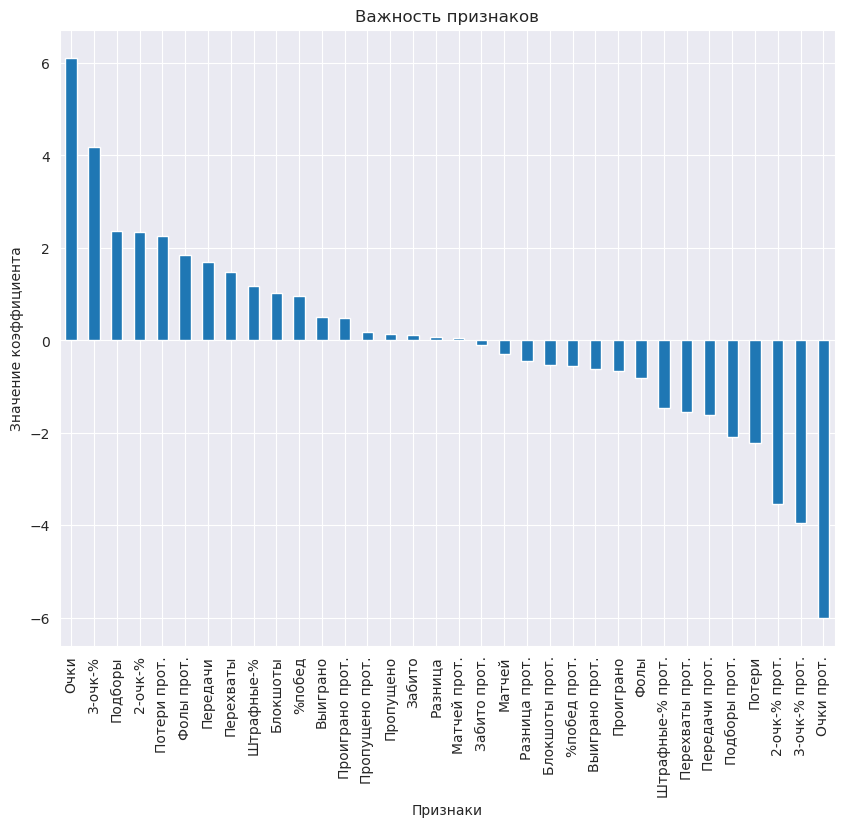

In [132]:
# График важности признаков
importance = pd.Series(lr.coef_[0], index=predictors).sort_values(ascending=False)

plt.figure(figsize=(10, 8))
importance.plot(kind='bar')
plt.title('Важность признаков')
plt.xlabel('Признаки')
plt.ylabel('Значение коэффициента')
plt.show()

In [140]:
res = f'Точность модели: {score} или {round(score * 100, 2)}%'
res

'Точность модели: 0.945859872611465 или 94.59%'

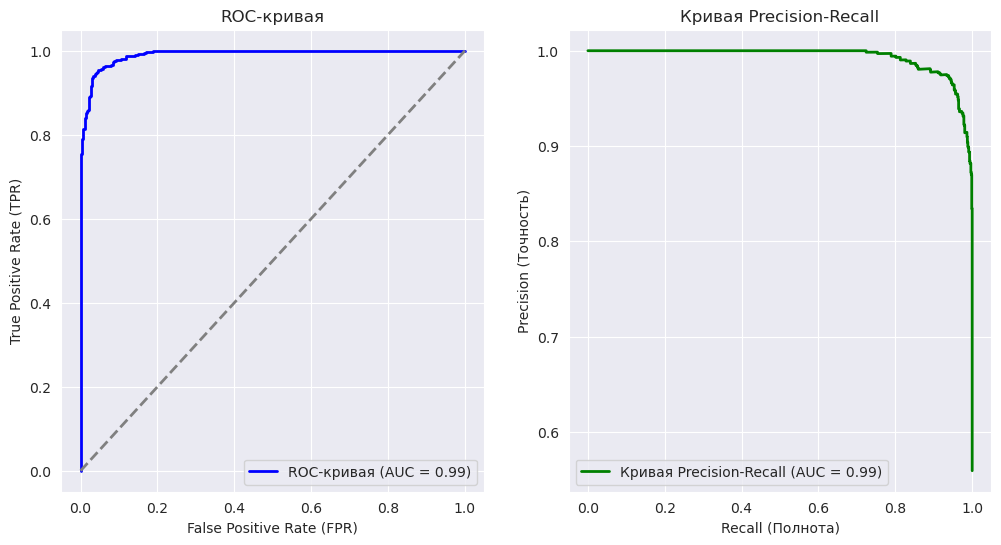

In [134]:
from sklearn.metrics import precision_recall_curve, auc, roc_curve

# Подготовка данных
y_true = dataset['Цель']
y_scores = lr.predict_proba(dataset[predictors])[:, 1]
# ROC-кривая
fpr, tpr, _ = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC-кривая (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC-кривая')
plt.legend(loc="lower right")

# Кривая Precision-Recall
precision, recall, _ = precision_recall_curve(y_true, y_scores)
pr_auc = auc(recall, precision)

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='green', lw=2, label=f'Кривая Precision-Recall (AUC = {pr_auc:.2f})')
plt.xlabel('Recall (Полнота)')
plt.ylabel('Precision (Точность)')
plt.title('Кривая Precision-Recall')
plt.legend(loc="lower left")

plt.show()

In [135]:
# Выборка данных команд по их названиям
def get_team_data(team, team_2):

    team_1_df = dataset[(dataset['Имя'] == team)]
    team_2_df = dataset[(dataset['Имя'] == team_2)]

    team_1_df['Сезон'] = pd.to_numeric(team_1_df['Сезон'])
    team_2_df['Сезон'] = pd.to_numeric(team_2_df['Сезон'])

    team_1_sorted = (team_1_df.sort_values(by='Сезон'))
    team_2_sorted = team_2_df.sort_values(by='Сезон')

    last_10_games_1 = team_1_sorted[predictors].tail(10).filter(regex='^(?!.*прот).*$')
    last_10_games_2 = team_2_sorted[predictors].tail(10).filter(regex='^(?!.*прот).*$').rename(
        columns=lambda x: f"{x} прот.")
    
    # Объединение статистики в один датафрейм
    combined = pd.concat([last_10_games_1.reset_index(drop=True), last_10_games_2.reset_index(drop=True)], axis=1)
    return combined.mean().to_frame().T.sort_index(axis=1)

In [168]:
t1 = 'ЦСКА'
t2 = 'Енисей'

pr_data = get_team_data(t1, t2)
pr_data = pr_data.loc[:, ~pr_data.columns.duplicated()].copy()

pred = lr.predict_proba(pr_data)

lose_probability = pred[0][0]
win_probability = pred[0][1]

if win_probability < 0.6:
    res = f'Вероятность победы в матче команды {t1} низкая: {round(pred[0][1] * 100, 2)}%, возможна победа {t2}'
elif win_probability > 0.75:
    res = f'Вероятность победы в матче команды {t1} крайне высокая: {round(pred[0][1] * 100, 2)}%. {t1} побеждает'
else: 
    res = f'Вероятность победы в матче команды {t1} высокая: {round(pred[0][1] * 100, 2)}%. {t1} побеждает'
if lose_probability > 0.5:
    res = f'Вероятность победы в матче команды {t1} крайне низкая: {round(pred[0][1] * 100, 2)}%. {t2} побеждает'


print(f'Вероятности команды {t1}:' + "\n", f'{pred[0][0]} - шанс проигрыша \n {pred[0][1]} - шанс выигрыша')


Вероятности команды ЦСКА:
 0.1828903869931211 - шанс проигрыша 
 0.8171096130068789 - шанс выигрыша


/tmp/ipykernel_7263/3355852811.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_1_df['Сезон'] = pd.to_numeric(team_1_df['Сезон'])
/tmp/ipykernel_7263/3355852811.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_2_df['Сезон'] = pd.to_numeric(team_2_df['Сезон'])


In [169]:
res

'Вероятность победы в матче команды ЦСКА крайне высокая: 81.71%. ЦСКА побеждает'

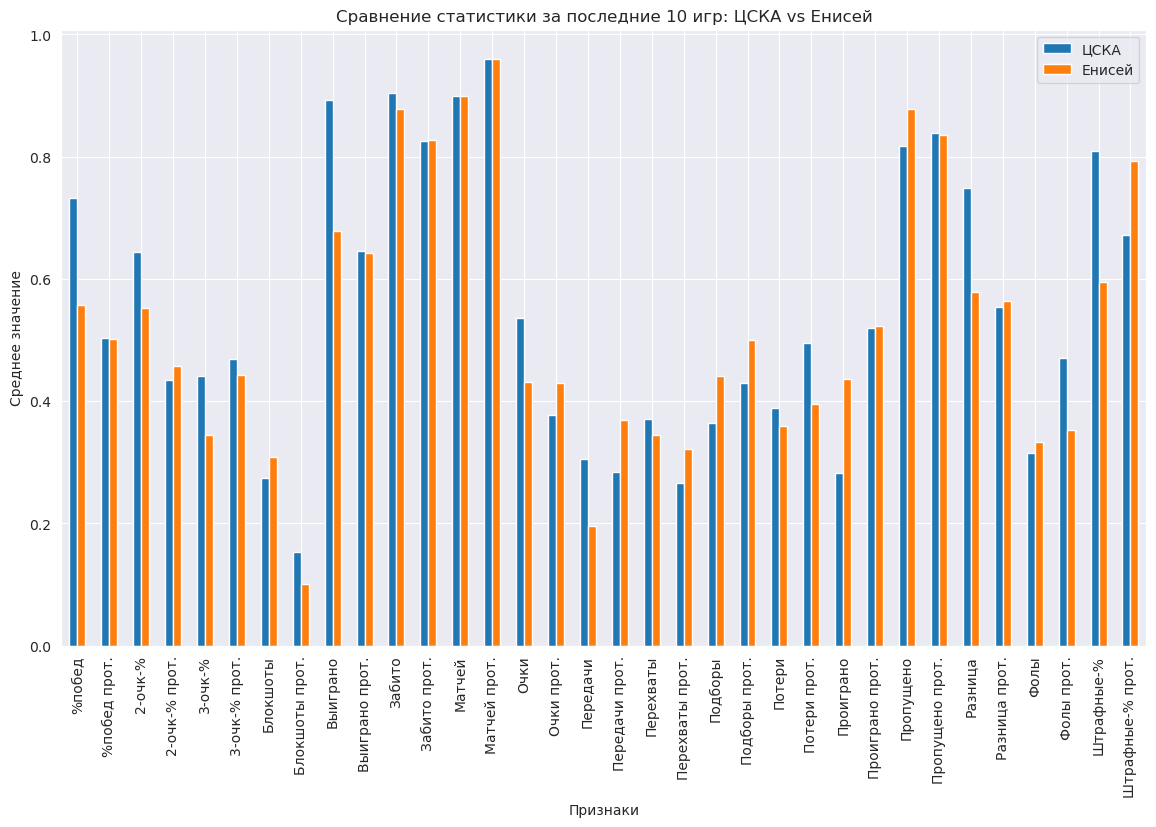

In [170]:
# Сравнение производительности команд
team_1_data = dataset[dataset['Имя'] == t1].tail(10)
team_2_data = dataset[dataset['Имя'] == t2].tail(10)

team_1_avg = team_1_data[predictors].mean()
team_2_avg = team_2_data[predictors].mean()

comparison_df = pd.DataFrame({f'{t1}': team_1_avg, f'{t2}': team_2_avg})
comparison_df.plot(kind='bar', figsize=(14, 8))
plt.title(f'Сравнение статистики за последние 10 игр: {t1} vs {t2}')
plt.xlabel('Признаки')
plt.ylabel('Среднее значение')
plt.show()

In [171]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import roc_auc_score, confusion_matrix, make_scorer

# Кросс-валидация с AUC метрикой
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
auc_scorer = make_scorer(roc_auc_score, multi_class='ovr')
scores = cross_val_score(lr, X, y, cv=kfold, scoring=auc_scorer)
print(f'AUC scores for each fold: {scores}')
print(f'Mean AUC: {np.mean(scores)}')
print(f'Standard deviation: {np.std(scores)}')

cm


AUC scores for each fold: [0.9421203  0.96081723 0.93216999 0.93487308 0.94700375]
Mean AUC: 0.943396867352568
Standard deviation: 0.010166670791479922


array([[118,  10],
       [  7, 179]])